<a href="https://colab.research.google.com/github/P-youngmin/DAP/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib
import seaborn as sns
import sklearn
import datetime
import json
import matplotlib.pyplot as plt
from datetime import timedelta

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
ls -1ha kaggle.json

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions list

In [ ]:
!kaggle datasets download -d rsrishav/youtube-trending-video-dataset

In [ ]:
!unzip youtube-trending-video-dataset.zip

# **주제: 유튜브 인기 동영상 분석**

Dataset 
*   YouTube Trending Video Dataset
*   https://www.kaggle.com/rsrishav/youtube-trending-video-dataset?select=KR_youtube_trending_data.csv



In [ ]:
df = pd.read_csv('KR_youtube_trending_data.csv')
df

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,uq5LClQN3cE,안녕하세요 보겸입니다,2020-08-09T09:32:48Z,UCu9BCtGIEr73LXZsKmoujKw,보겸 BK,24,2020-08-12T00:00:00Z,보겸|bokyem,5947503,53326,105756,139946,https://i.ytimg.com/vi/uq5LClQN3cE/default.jpg,False,False,NaN
1,I-ZbZCHsHD0,부락토스의 계획 [총몇명 프리퀄],2020-08-12T09:00:08Z,UCRuSxVu4iqTK5kCh90ntAgA,총몇명,1,2020-08-12T00:00:00Z,총몇명|재밌는 만화|부락토스|루시퍼|총몇명 프리퀄|총몇명 스토리,963384,28244,494,3339,https://i.ytimg.com/vi/I-ZbZCHsHD0/default.jpg,False,False,"오늘도 정말 감사드립니다!!총몇명 스튜디오 - 총몇명, 십제곱, 5G민, MOVE혁..."
2,9d7jNUjBoss,평생 반성하면서 살겠습니다.,2020-08-10T09:54:13Z,UCMVC92EOs9yDJG5JS-CMesQ,양팡 YangPang,22,2020-08-12T00:00:00Z,양팡|양팡유튜브|팡튜브|가족시트콤|양팡가족|양팡가족시트콤|양팡언니|현실남매|현실자매...,2950885,17974,68898,50688,https://i.ytimg.com/vi/9d7jNUjBoss/default.jpg,False,False,NaN
3,3pI_L3-sMVg,안녕하세요 꽈뚜룹입니다.,2020-08-11T15:00:58Z,UCkQCwnkQfgSuPTTnw_Y7v7w,꽈뚜룹 Quaddurup,24,2020-08-12T00:00:00Z,꽈뚜룹|한국여행기|quaddurup|뚜룹이|korea|southkorea|vlog|...,1743374,36893,1798,8751,https://i.ytimg.com/vi/3pI_L3-sMVg/default.jpg,False,False,앞으로 좀 더 깔끔한 영상제작 약속 드리겠습니다.늘 감사드립니다
4,zrsBjYukE8s,박진영 (J.Y. Park) When We Disco (Duet with 선미) M/V,2020-08-11T09:00:13Z,UCaO6TYtlC8U5ttz62hTrZgg,JYP Entertainment,10,2020-08-12T00:00:00Z,JYP Entertainment|JYP|J.Y.Park|JYPark|박진영|선미|S...,3433885,353337,9763,23405,https://i.ytimg.com/vi/zrsBjYukE8s/default.jpg,False,False,MelOn http://kko.to/TWyXd7zYjSpotify https://s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96949,9MhwHkKW5UU,"Brawl Stars: Brawl Talk - 2 NEW BRAWLERS, BRAW...",2021-12-11T16:00:10Z,UCooVYzDxdwTtGYAkcPmOgOw,Brawl Stars,20,2021-12-20T00:00:00Z,brawl stars|mobile game|mobile strategy game|m...,13541547,616533,0,30285,https://i.ytimg.com/vi/9MhwHkKW5UU/default.jpg,False,False,Download NOW!! ►► https://supr.cl/playbrawlBe ...
96950,SElEK7mwca4,참 좋은 날,2021-12-09T09:10:32Z,UClch5s6f5W3YPW3CK7BDDTg,Lee Chanwon - Topic,10,2021-12-20T00:00:00Z,이찬원|참 좋은 날,1036167,22050,0,0,https://i.ytimg.com/vi/SElEK7mwca4/default.jpg,False,False,Provided to YouTube by UMAG참 좋은 날 · 이찬원참 좋은 날℗...
96951,Q3irgGha6Bc,[#유퀴즈온더블럭] 아빠 어디가 당시 윤민수와 안 친했다?! 어느새 훌쩍 커서 소년...,2021-12-11T13:26:01Z,UCsRIHt5FkbGc6cQtCxt-ufA,tvN D ENT,24,2021-12-20T00:00:00Z,AKMU|Diggle|tvN|tvN D ENT|갓구운 유퀴즈|갓구운클립|국가대표 이...,2175003,20311,0,2075,https://i.ytimg.com/vi/Q3irgGha6Bc/default.jpg,False,False,"#유퀴즈온더블럭 #Diggle #디글 Let's giggle, :Diggle!구독하..."
96952,x50ZfvS9QpQ,인도 6만원짜리 5성급 호텔 후기 - 해외3,2021-12-12T08:27:33Z,UCxU8QX7IRRIW0VLuoWWoxbw,여행가 제이 [Jay world traveler],19,2021-12-20T00:00:00Z,브이로그|vlog|휴식|휴가|여행|인도|세계여행|대도시|첸나이|5성급|호텔|호캉스,277286,6060,0,792,https://i.ytimg.com/vi/x50ZfvS9QpQ/default.jpg,False,False,원래 계획은 북인도에서부터 시작해서 남인도로 내려와서남인도에 살고 있는 친구들을 보...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96954 entries, 0 to 96953
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           96954 non-null  object
 1   title              96954 non-null  object
 2   publishedAt        96954 non-null  object
 3   channelId          96954 non-null  object
 4   channelTitle       96954 non-null  object
 5   categoryId         96954 non-null  int64 
 6   trending_date      96954 non-null  object
 7   tags               96954 non-null  object
 8   view_count         96954 non-null  int64 
 9   likes              96954 non-null  int64 
 10  dislikes           96954 non-null  int64 
 11  comment_count      96954 non-null  int64 
 12  thumbnail_link     96954 non-null  object
 13  comments_disabled  96954 non-null  bool  
 14  ratings_disabled   96954 non-null  bool  
 15  description        94714 non-null  object
dtypes: bool(2), int64(5), object(9)
memory u

### 시간의 데이터 타입들을 Datetime으로 변환

In [ ]:
df['trending_date'] = pd.to_datetime(df['trending_date'])
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

### 인기동영상으로 등록되는데 걸린 시간을 추가한다.

In [ ]:
df["tre_pubtime"] = df["trending_date"] - df["publishedAt"] + timedelta(days = 1)


### 인기동영상에서 같은 영상이 다른 날짜에 중복해서 집계되는 경우를 확인한다.

In [ ]:
df["video_id"].duplicated().value_counts()

True     84055
False    12899
Name: video_id, dtype: int64

### 중복되는 영상들을 제거한다.

In [ ]:
df = df.drop_duplicates(["video_id"])[:]

In [ ]:
df["video_id"].duplicated().value_counts()

False    12899
Name: video_id, dtype: int64

### 값들의 관계를 추가

In [ ]:
df["likes/view_count"] = df["likes"] / df["view_count"]
df["dislikes/view_count"] = df["dislikes"] / df["view_count"]
df["comment_count/view_count"] = df["comment_count"] / df["view_count"]

In [ ]:
df.isnull().sum()

video_id                      0
title                         0
publishedAt                   0
channelId                     0
channelTitle                  0
categoryId                    0
trending_date                 0
tags                          0
view_count                    0
likes                         0
dislikes                      0
comment_count                 0
thumbnail_link                0
comments_disabled             0
ratings_disabled              0
description                 337
tre_pubtime                   0
likes/view_count              1
dislikes/view_count           1
comment_count/view_count      1
dtype: int64

### dislikes/view_count 값과 comment_count/view_count 값에 null값이 들어가있는데 이유를 찾아보니 view_count 값이 0인 영상들이 있었다. 0인데 인기동영상에 올라와있는 이유를 찾아보니 유튜브 자체에서 캠패인 같은 식으로 제작한 영상은 조회수가 따로 집계되지 않아 그런것 같다. 특이한 케이스이고 null값을 없애주기 위해서 조회수가 0인 동영상 들은 제외해 주었다.

In [ ]:
df = df[df.view_count != 0]

### 분석에 사용하지 않는 값들은 삭제한다.

In [ ]:
df= df.drop(['comments_disabled','ratings_disabled','description','thumbnail_link'],axis='columns')

In [ ]:
id_to_category = {}

with open("./KR_category_id.json","r") as f:
    id_data = json.load(f)
    for category in id_data["items"]:
        id_to_category[category["id"]] = category["snippet"]["title"]

df["categoryId"] = df["categoryId"].astype(str)
df.insert(4, "category", df["categoryId"].map(id_to_category))

In [ ]:
df.head()

,video_id,title,publishedAt,channelId,category,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,tre_pubtime,likes/view_count,dislikes/view_count,comment_count/view_count
0,uq5LClQN3cE,안녕하세요 보겸입니다,2020-08-09 09:32:48+00:00,UCu9BCtGIEr73LXZsKmoujKw,Entertainment,보겸 BK,24,2020-08-12 00:00:00+00:00,보겸|bokyem,5947503,53326,105756,139946,3 days 14:27:12,0.008966,0.017782,0.023530
1,I-ZbZCHsHD0,부락토스의 계획 [총몇명 프리퀄],2020-08-12 09:00:08+00:00,UCRuSxVu4iqTK5kCh90ntAgA,Film & Animation,총몇명,1,2020-08-12 00:00:00+00:00,총몇명|재밌는 만화|부락토스|루시퍼|총몇명 프리퀄|총몇명 스토리,963384,28244,494,3339,0 days 14:59:52,0.029317,0.000513,0.003466
2,9d7jNUjBoss,평생 반성하면서 살겠습니다.,2020-08-10 09:54:13+00:00,UCMVC92EOs9yDJG5JS-CMesQ,People & Blogs,양팡 YangPang,22,2020-08-12 00:00:00+00:00,양팡|양팡유튜브|팡튜브|가족시트콤|양팡가족|양팡가족시트콤|양팡언니|현실남매|현실자매...,2950885,17974,68898,50688,2 days 14:05:47,0.006091,0.023348,0.017177
3,3pI_L3-sMVg,안녕하세요 꽈뚜룹입니다.,2020-08-11 15:00:58+00:00,UCkQCwnkQfgSuPTTnw_Y7v7w,Entertainment,꽈뚜룹 Quaddurup,24,2020-08-12 00:00:00+00:00,꽈뚜룹|한국여행기|quaddurup|뚜룹이|korea|southkorea|vlog|...,1743374,36893,1798,8751,1 days 08:59:02,0.021162,0.001031,0.005020
4,zrsBjYukE8s,박진영 (J.Y. Park) When We Disco (Duet with 선미) M/V,2020-08-11 09:00:13+00:00,UCaO6TYtlC8U5ttz62hTrZgg,Music,JYP Entertainment,10,2020-08-12 00:00:00+00:00,JYP Entertainment|JYP|J.Y.Park|JYPark|박진영|선미|S...,3433885,353337,9763,23405,1 days 14:59:47,0.102897,0.002843,0.006816


# **조회수**

### 인기동영상의 조회수의 최대, 최소, 평균 값을 구한다.

조회수 평균 :779062.35
조회수 최대값 :76805026.00
조회수 최소값 :14209.00


(array([1.2747e+04, 9.6000e+01, 2.4000e+01, 1.1000e+01, 1.0000e+01,
        4.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.42090000e+04, 7.69329070e+06, 1.53723724e+07, 2.30514541e+07,
        3.07305358e+07, 3.84096175e+07, 4.60886992e+07, 5.37677809e+07,
        6.14468626e+07, 6.91259443e+07, 7.68050260e+07]),
 <a list of 10 Patch objects>)

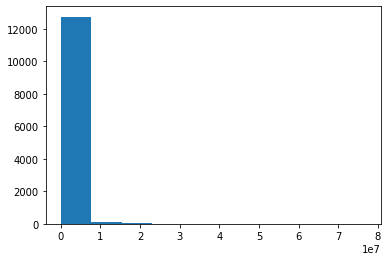

In [ ]:
print("조회수 평균 :{:.2f}".format(df['view_count'].mean()))
print("조회수 최대값 :{:.2f}".format(df['view_count'].max()))
print("조회수 최소값 :{:.2f}".format(df['view_count'].min()))

plt.hist(df['view_count'])

### 최대값과 평균의 차이가 매우 크고 표가 한 곳으로 몰린 것을 보아 outlier가 존재한다는 것을 알 수 있다.

### 조회수가 0인 경우와 아웃라이어를 제거하고 다시 구해보았다.

In [ ]:
Q1 = df['view_count'].quantile(.20)
Q3 = df['view_count'].quantile(.80)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR

filtered_view_df = df[(df['view_count'] < Q3 + outlier_step)]
filtered_view_df[["view_count"]].describe()

print("조회수 평균 :{:.2f}".format(filtered_view_df['view_count'].mean()))
print("조회수 최대값 :{:.2f}".format(filtered_view_df['view_count'].max()))
print("조회수 최소값 :{:.2f}".format(filtered_view_df['view_count'].min()))

조회수 평균 :439868.71
조회수 최대값 :1878173.00
조회수 최소값 :14209.00


(array([3985., 3209., 1693., 1093.,  729.,  523.,  363.,  226.,  171.,
         126.]),
 array([  14209. ,  200605.4,  387001.8,  573398.2,  759794.6,  946191. ,
        1132587.4, 1318983.8, 1505380.2, 1691776.6, 1878173. ]),
 <a list of 10 Patch objects>)

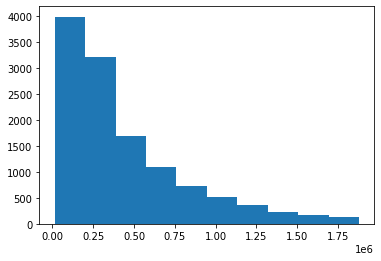

In [ ]:
plt.hist(filtered_view_df['view_count'])

### 위의 결과로 생각해 봤을때 인기동영상은 최소 14000의 조회수를 갖고
### 평균적으로 440000의 조회수를 같는 것을 알 수있다.


### 조회수와 같이 좋아요와 싫어요도 분석해 보았다.

In [ ]:
like_df = df[df.likes != 0]
Q1 = like_df['likes'].quantile(.20)
Q3 = like_df['likes'].quantile(.80)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR
filtered_like_df = like_df[(like_df['likes'] < Q3 + outlier_step)]

dislike_df = df[df.dislikes != 0]
Q1 = dislike_df['dislikes'].quantile(.20)
Q3 = dislike_df['dislikes'].quantile(.80)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR
filtered_dislike_df = dislike_df[(dislike_df['dislikes'] < Q3 + outlier_step)]



print("좋아요 평균 :{:.2f}".format(filtered_like_df['likes'].mean()))
print("좋아요 최대값 :{:.2f}".format(filtered_like_df['likes'].max()))
print("좋아요 최소값 :{:.2f}".format(filtered_like_df['likes'].min()))
print("")
print("싫어요 평균 :{:.2f}".format(filtered_dislike_df['dislikes'].mean()))
print("싫어요 최대값 :{:.2f}".format(filtered_dislike_df['dislikes'].max()))
print("싫어요 최소값 :{:.2f}".format(filtered_dislike_df['dislikes'].min()))

좋아요 평균 :9713.21
좋아요 최대값 :50656.00
좋아요 최소값 :70.00

싫어요 평균 :178.21
싫어요 최대값 :839.00
싫어요 최소값 :2.00


# **좋아요, 싫어요, 댓글수의 관계**





In [ ]:
df[["likes/view_count", "dislikes/view_count", "comment_count/view_count"]].describe()

,likes/view_count,dislikes/view_count,comment_count/view_count
count,12897.000000,12897.000000,12897.000000
mean,0.039904,0.000692,0.004564
std,0.048577,0.001810,0.005479
min,0.000000,0.000000,0.000000
25%,0.013618,0.000256,0.001567
50%,0.022548,0.000402,0.003011
75%,0.040780,0.000667,0.005512
max,0.408681,0.077554,0.161516


### 위의 내용을 보면 조회수와 비교해서 좋아요와 싫어요, 댓글수의 평균과 최소, 최대 값을 알 수 있다.

### 평균적으로 좋아요는 3%, 싫어요는 0.06%, 댓글수는 0.4%인 것을 알 수 있다.

# **카테고리**

<function matplotlib.pyplot.show>

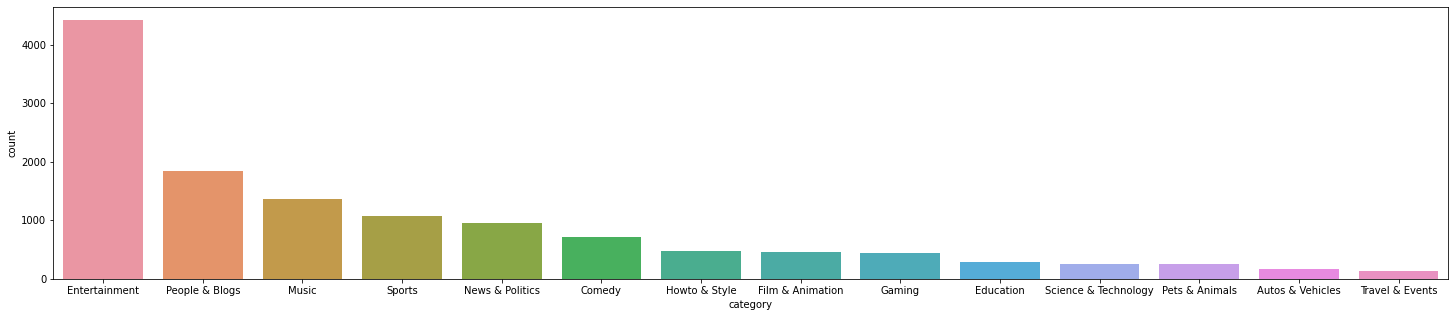

In [ ]:
plt.figure(figsize=(25,5))
sns.countplot(x = 'category', data = df, order = df['category'].value_counts().index)
plt.show

전체 인기동영상의 카테고리 숫자를 카운트해보면 위의 그래프와 같이

Entertainment, People & Blogs, Music 순으로 많은 것을 볼수 있고

### 특히 Entertainment가 많이 카운트 된 것을 볼 수 이다.

<function matplotlib.pyplot.show>

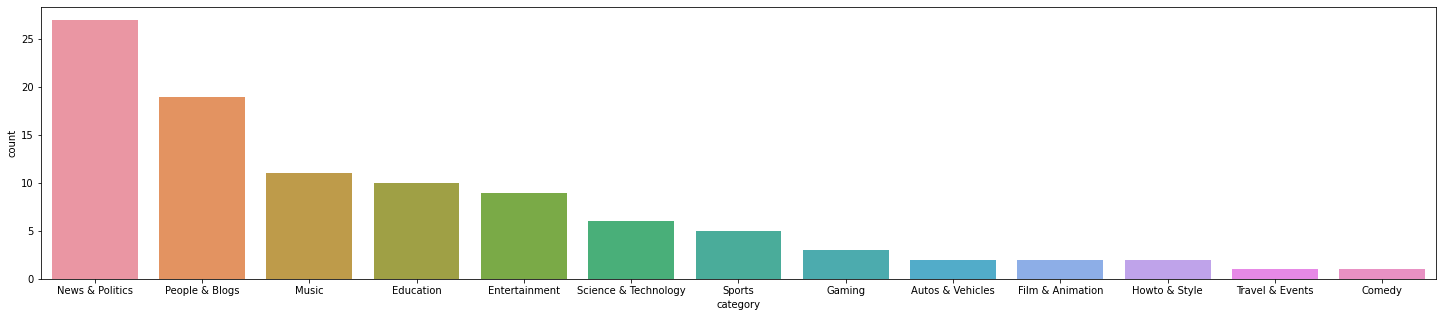

In [ ]:
sort_view_df = df.sort_values(by=['view_count'], axis=0)
top100_df = sort_view_df.head(100)
plt.figure(figsize=(25,5))
sns.countplot(x = 'category', data = top100_df, order = top100_df['category'].value_counts().index)
plt.show

### 위의 그래프는 조회수 순으로 정렬해서 상위 100개의 영상들의 카테고리를 분류해서 카운트 한 경우인데 상위 조회수를 가진 영상들의 경우 News & Politics 카테고리가 많다는 것을 알 수 있다.

# **인기 동영상에 등록되는데 걸린 시간**

In [ ]:
df[["tre_pubtime"]].describe()

,tre_pubtime
count,12897
mean,1 days 20:31:36.485616810
std,0 days 23:08:13.501776435
min,0 days 11:47:11
25%,1 days 11:59:44
50%,1 days 14:59:38
75%,1 days 20:01:38
max,22 days 13:55:07


평균적으로 1일 20시간 정도 걸리는 것을 알 수 있다.

# **관계**

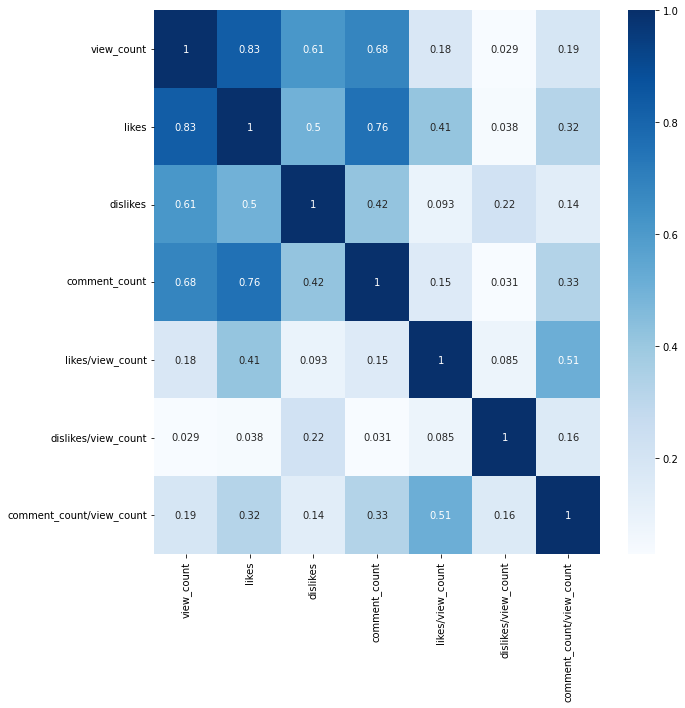

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(),cmap="Blues",annot=True)

# **정리**



### *   유튜브 인기 동영상은 평균 440000회의 조회수를 가지고 있고 최소 14000회의 조회수를 가지고 있다.

### *   인기 동영상의 조회수 대비 좋아요의 비율은 평균적으로 3%이고 싫어요의 비율은 평균적으로 0.06%이며 댓글 수는 0.4%이다.
### *   전체 인기 동영상의 카테고리는 Entertainment가 압도적으로 많고 People & Blogs, Music가 많이 차지 하고 있지만 상위 100개의 동영상 중에서는  News & Politics가 가장 많이 차지하고 있다.


### *   평균적으로 영상을 올리고 인기 동영상으로 선정되는데 걸리는 시간이 1일 20시간 정도이다.

